>reference：[多元时间序列分析](https://zhuanlan.zhihu.com/p/662566617)

>data：[AustralianWine](https://github.com/vcerqueira/blog)

In [83]:
#base tool
import pandas as pd
import numpy as np
import qstock as qs
import matplotlib.pyplot as plt
import warnings
import requests

#var
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

#协整分析
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen

#VECM分析
from statsmodels.tsa.vector_ar.vecm import coint_johansen,VECM

#格兰杰因果检验
from statsmodels.tsa.stattools import grangercausalitytests

warnings.filterwarnings('ignore')

In [84]:
# codes=qs.get_code()
# codes=['沪深300ETF','国债ETF','大宗商品ETF']
# df=qs.get_price("中国平安",start='20200101',fqt=2).dropna()
# # result = requests.get(api,verify=False).text.encode('utf-8')
# qs.realtime_data(code=['中国平安','300684','锂电池ETF','BK0679','上证指数'])
# df=qs.get_data('601318')

In [85]:
df = pd.read_csv("wine.csv")


In [86]:
#判断序列是否平稳，如果不平稳需要进行差分

def test_stationarity(timeseries):
    dftest=adfuller(timeseries,autolag='AIC')
    return dftest[1]<0.05

#差分直到序列平稳
def difference_until_stationary(df):
    while not df.apply(test_stationarity).all():
        df=df.diff().dropna()
    return df

#对数收益率，一般是平稳序列

returns=np.log(df/df.shift(1)).dropna()

# 估计VAR模型

+ 确定滞后阶数（lag order selection）：使用信息准则（如AIC、BIC）或统计检验（如Ljung-Box检验）来确定VAR模型的合适滞后阶数。使用模型选择方法，如逐步回归或网格搜索，来找到最优的滞后阶数。
  
+ 使用选定的滞后阶数，通过最小二乘法（OLS）或其他估计方法，估计VAR模型的系数矩阵。计算模型的标准误差、残差和协方差矩阵。

In [87]:
model=VAR(endog=returns)
lags=range(1,10)
criterion='aic'#or'bic'

#使用循环计算每个滞后阶数的AIC或BIC值

criteria=[]
for lag in lags:
    result=model.fit(lag)
    criteria.append(result.info_criteria[criterion])

#找到AIC或BIC值最小的滞后阶数
best_lag=lags[criteria.index(min(criteria))]

#估计模型参数
results=model.fit(best_lag)

#输出VAR回归结果
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Jun, 2024
Time:                     15:11:33
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -19.4624
Nobs:                     164.000    HQIC:                  -24.4927
Log likelihood:           1109.35    FPE:                1.00649e-12
AIC:                     -27.9304    Det(Omega_mle):     1.00270e-13
--------------------------------------------------------------------
Results for equation Total
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.000784         0.013900           -0.056           0.955
L1.Total             -0.983198         0.178088           -5.521           0.000
L1.Drywhite           0.071539         0.160658            0

In [88]:
def show_result(df):
    results_df=pd.DataFrame()
    for var in results.names:
        coeffs=results.params[var].round(3)
        pvalues=results.pvalues[var].round(3)
    for i in range(len(pvalues)):
        if pvalues[i]<0.01:
            coeffs[i]=str(coeffs[i])+'***'
        elif pvalues[i]<0.05:
            coeffs[i]=str(coeffs[i])+'**'
        elif pvalues[i]<0.1:
            coeffs[i]=str(coeffs[i])+'*'
    results_df[var+'_coeff']=coeffs
    results_df[var+'_pvalue']=pvalues
    return results_df

show_result(results)



,Sweetwhite_coeff,Sweetwhite_pvalue
const,0.018,0.417
L1.Total,-0.123,0.667
L1.Drywhite,-0.203,0.430
L1.Fortified,0.242,0.216
L1.Red,0.136,0.546
...,...,...
L9.Fortified,0.11,0.577
L9.Red,0.193,0.384
L9.Rose,0.003,0.982
L9.Sparkling,0.082,0.611


# 模型诊断：
+ 检查模型的残差序列是否满足白噪声假设，可以进行残差平稳性检验、正态性检验和自相关性检验。
+ 如果残差序列存在问题，可以尝试使用适当的修正模型，如VECM模型或SVAR模型。
  
# 预测和脉冲响应分析
+ 使用估计的VAR模型进行未来期的预测。可以使用滚动窗口法进行逐步预测，或使用整体样本进行一次性预测。
+ 计算预测值的置信区间，以评估预测的不确定性。

## 脉冲响应分析：
+ 计算脉冲响应函数（Impulse Response Function，IRF），以衡量一个变量对其他变量的冲击响应。
+ 分析脉冲响应曲线，观察冲击对各变量的影响强度、持续时间和传导效应。
+ 绘制脉冲响应函数图表或计算累积脉冲响应函数（Cumulative Impulse Response Function，CIRF）来进一步分析


脉冲响应分析是一种用于研究VAR模型中冲击的传导效应的方法，可以帮助我们理解不同变量之间的相互作用和反应。在VAR模型中，脉冲响应函数展示了一个变量对于其他变量的冲击作用下的动态响应。通过分析脉冲响应函数，我们可以得出以下几个方面的评估：

1. 冲击的传导路径：脉冲响应函数展示了冲击如何在不同变量之间传导。通过观察响应函数的图形，我们可以确定冲击从一个变量到另一个变量的传导路径。这对于理解金融市场中冲击的扩散和传播机制非常重要。

2. 响应的强度和持续时间：脉冲响应函数还显示了响应的强度和持续时间。通过分析响应函数的幅度和持续时间，我们可以评估不同变量之间的冲击传导的强度和持久性。这有助于确定系统中哪些变量对冲击更敏感，以及冲击的影响会持续多久。

3. 系统性风险的评估：脉冲响应分析还可以帮助评估金融市场的系统性风险。通过分析响应函数的图形，我们可以确定系统中的关键变量，它们对冲击的响应程度是否高于其他变量。这有助于识别系统中的脆弱性和潜在的风险传导路径，从而更好地评估系统性风险。

## 关于图形的解读：

+ 坐标轴解释：脉冲响应图通常具有两个坐标轴，一个表示时间或滞后阶数，另一个表示变量。时间轴显示了观察的时间段或滞后的数量，而变量轴显示了参与模型的变量。
+ 线条解释：脉冲响应图上的每条线表示一个变量对于其他变量的冲击传导效应。每个变量都有一条线，通过线的形状和趋势，可以分析冲击的传导路径和强度。
+ 线条的方向：线条的方向显示了冲击的传导方向。如果线条从一个变量向另一个变量延伸，表示冲击从前者传导到后者。通过观察线条的延伸方向，可以确定冲击的传导路径。
+ 线条的幅度：线条的幅度表示了冲击的强度。较大的幅度表示较强的冲击效应，而较小的幅度表示较弱的冲击效应。通过比较不同线条的幅度，可以评估不同变量之间冲击传导的强度。
+ 线条的形状和趋势：线条的形状和趋势显示了冲击的持续时间和衰减程度。如果线条在初始冲击后逐渐衰减，并最终趋于稳定，表示冲击效应是短暂的。如果线条在初始冲击后保持较高的幅度，并逐渐趋于零，表示冲击效应是持久的。

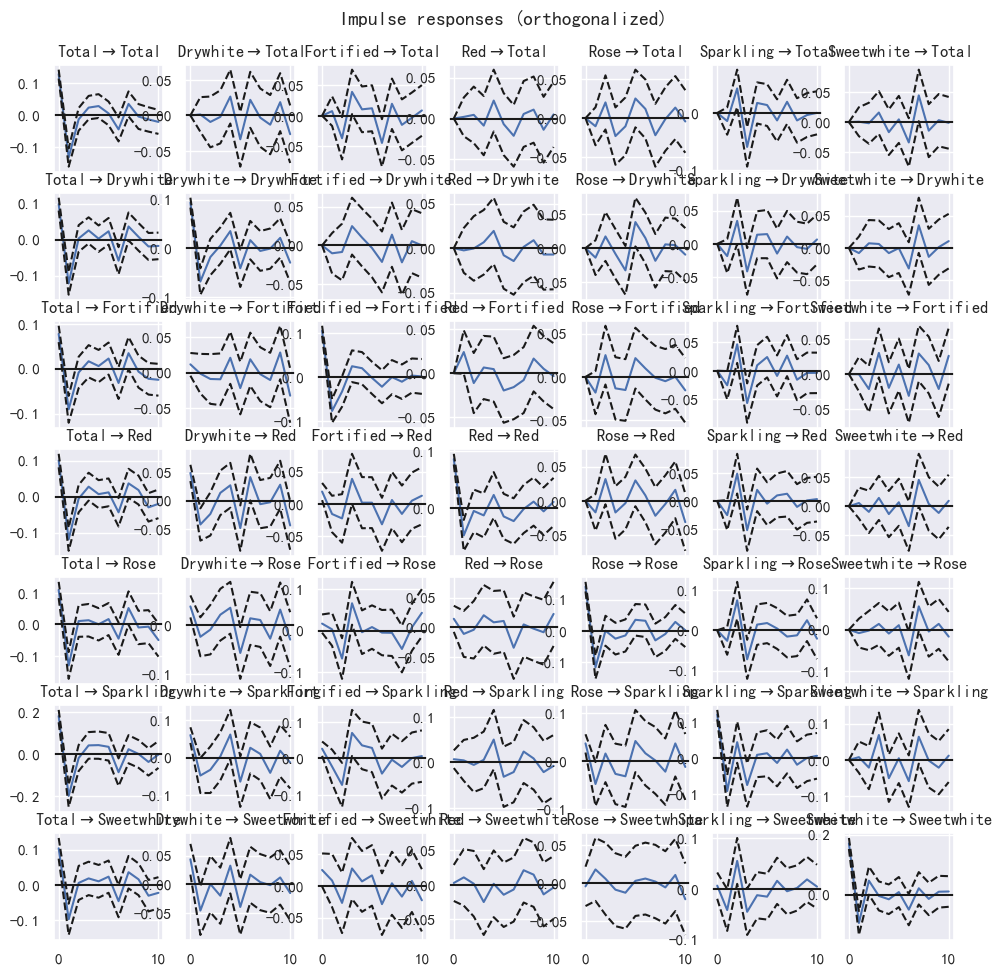

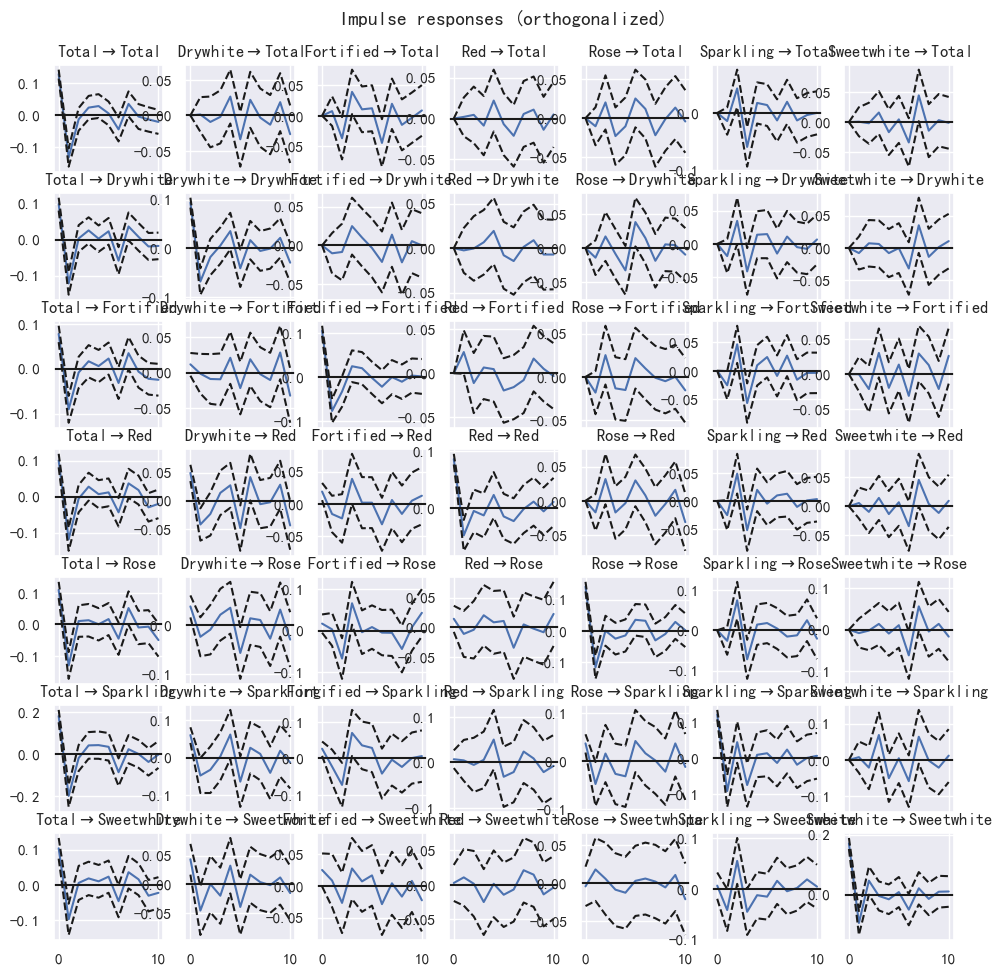

In [89]:
#预测
forecast=results.forecast(returns.values[-best_lag:],steps=10)#预测未来10个时间步长

#脉冲响应分析
irf=results.irf(10)#计算脉冲响应函数
irf.plot(orth=True)#绘制脉冲响应函数图表

# 协整分析

+    在时间序列分析中，我们常常遇到这样一种情况：单独看，一个时间序列可能是非平稳的，但是将两个或者多个非平稳时间序列进行某种线性组合后，得到的新序列却是平稳的。如果存在这样的线性组合，我们就说这些序列之间存在协整关系。从数学语言来理解，设有n个非平稳时间序列X1, X2, …, Xn，如果存在一个向量β=(β1, β2, …, βn)，使得序列Z=β1X1+β2X2+…+βnXn是平稳的，那么我们就说这n个序列存在协整关系

+    statsmodels库的coint函数基于Engle-Granger两步法进行协整检验。这是一种常用的协整检验方法，但并不是唯一的方法。其他的协整检验方法，比如Johansen协整检验，可能会得到不同的结果。不同的协整检验方法可能会对样本数据的特性、数据的处理方法、检验的假设等有不同的要求，因此可能会得到不同的检验结果。Johansen协整检验和Engle-Granger协整检验的原假设是不同的。Engle-Granger协整检验的原假设是存在协整关系，而Johansen协整检验的原假设是不存在协整关系。因此，在解读检验结果时需要注意这个差异。

In [90]:
#基于coint的协整检验

def check_coint(df):

    s1=df.iloc[:,0]
    s2=df.iloc[:,1]

    coint_t,p_value,crit_value=coint(s1,s2)
    if p_value<0.05:
        return True
    else: return False

#基于Johansen的协整检验

def check_johansen(df):

#进行Johansen协整检验
    johansen_test=coint_johansen(df.values,det_order=0,k_ar_diff=1)

#判断是否存在协整关系
    if johansen_test.lr1[0]>johansen_test.cvt[0,1]:#5%显著性水平
        return True
    else: return False

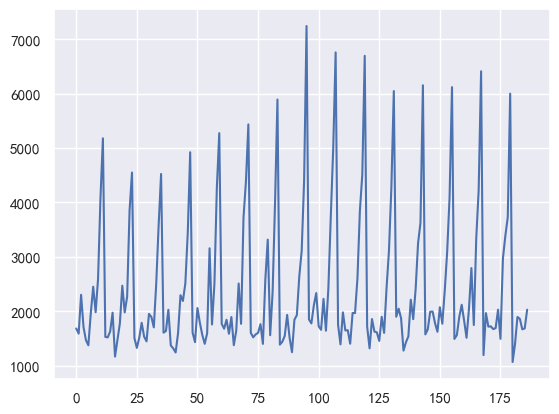

In [91]:
data=pd.read_csv("wine.csv")
data=data.fillna(method='pad',axis=0)
plt.plot(data["Sparkling"])
plt.show()

In [92]:
# codes=['sh','sz','sz50','cyb','hs300','zxb']

# data=qs.get_price(codes,start='20240620',freq='w').dropna()[-200:]

# #价格走势对比
# fig,ax=plt.subplots(3,2,figsize=(12,10))
# k=0
# for i in range(3):
#     for j in range(2):
#         data.iloc[:,k].plot(ax=ax[i,j])
#         ax[i,j].set_title(data.columns[k])
#     k+=1

# plt.tight_layout()

In [93]:
import itertools

ss=[list(i) for i in list(itertools.combinations(data.columns,2))]
print("coint")
for i in range(len(ss)):
    if check_coint(data[ss[i]]):
        print(f'{ss[i]}存在协整关系')

print("johansen")
for i in range(len(ss)):
    if check_johansen(data[ss[i]]):
        print(f'{ss[i]}存在协整关系')

coint
johansen
['Total', 'Drywhite']存在协整关系
['Total', 'Fortified']存在协整关系
['Total', 'Red']存在协整关系
['Total', 'Rose']存在协整关系
['Total', 'Sparkling']存在协整关系
['Total', 'Sweetwhite']存在协整关系
['Drywhite', 'Fortified']存在协整关系
['Drywhite', 'Red']存在协整关系
['Drywhite', 'Rose']存在协整关系
['Drywhite', 'Sparkling']存在协整关系
['Drywhite', 'Sweetwhite']存在协整关系
['Fortified', 'Red']存在协整关系
['Fortified', 'Rose']存在协整关系
['Fortified', 'Sparkling']存在协整关系
['Fortified', 'Sweetwhite']存在协整关系
['Red', 'Rose']存在协整关系
['Red', 'Sparkling']存在协整关系
['Red', 'Sweetwhite']存在协整关系
['Rose', 'Sparkling']存在协整关系
['Rose', 'Sweetwhite']存在协整关系
['Sparkling', 'Sweetwhite']存在协整关系


上述结果显示，基于coint和Johansen函数进行协整检验存在一些差异。值得注意的是，协整检验的结果可能会受到样本的影响，例如样本数量的多少、样本的选择等都可能会影响到检验的结果。因此，除了协整检验，还需要结合实际情况和其他方法来确定是否存在协整关系。

此外，相关性和协整性是两个不同的概念。它们虽然在某些情况下可能会有所关联，但在许多情况下它们并不一定会同时存在。即使两个变量具有高度的相关性，它们也可能不具有协整性，因为它们可能并没有长期的稳定关系。反之，即使两个变量在短期内的相关性不高，只要它们之间存在长期的稳定关系，它们就可能是协整的。在实际研究中，我们需要根据研究的目的和问题的性质，选择适当的方法来研究变量之间的关系。

协整分析在金融市场上有着广泛的应用。以下是一些主要的应用场景：

+ 配对交易（Pairs Trading）：这是协整分析在金融领域中最广泛的应用之一。配对交易的策略是找出两只协整的股票，当它们的价格差距超过历史平均水平时，就会进行交易，购买价格较低的股票，同时卖空价格较高的股票，等待价格回归到均衡状态来获取利润。
+ 风险管理：在多元投资组合管理中，协整分析可以帮助识别各种资产之间的长期稳定关系，这对于风险管理和投资组合优化非常重要。通过找出协整的资产，投资者可以构建出稳定的投资组合，降低风险。
+ 预测和决策：由于协整关系反映了一种长期的均衡状态，因此在经济决策和预测中，协整分析也非常有用。比如，经济政策制定者可以通过分析宏观经济指标的协整关系来预测未来的经济趋势，为政策决策提供依据。
+ 套利策略：在金融市场上，协整关系也常常被用来寻找套利机会。比如，如果两个不同国家的债券市场存在协整关系，那么当两个市场的价格出现偏离时，交易员就可以在一个市场购买，同时在另一个市场卖空，等待价格恢复到均衡状态时再平仓，从而获取无风险收益。
这些只是协整分析在金融市场上的一部分应用，实际上，只要是涉及多个时间序列的分析问题，协整分析都可能发挥重要作用。

# 向量误差修正模型（VECM）

向量误差修正模型（Vector Error Correction Model, VECM）是多元时间序列分析的一个重要工具，用于处理存在协整关系的变量间的长期均衡关系以及短期调整动态。在金融领域，例如股票市场分析、经济预测、风险管理等，VECM的应用十分广泛。

VECM是VAR模型的扩展，它在VAR的基础上添加了一个长期均衡误差项。这是因为实际中许多经济和金融序列间不仅存在短期内的因果关系，还存在长期的均衡关系。当这种均衡关系被短期冲击打破后，系统会通过调整各变量使得整个系统重新回归均衡状态，VECM就是在描述这个过程。

> ![alt text](image.png)

其中， 是一个 k 维的向量，Π是一个 kk 矩阵，表示长期的均衡关系， 是一个 kk 矩阵，表示短期的动态调整， 是误差项。

我们以股票市场为例进行说明。假设我们关注两只股票A和B，希望通过对它们的历史价格数据建立VECM模型，以此来分析两只股票之间的长短期关系并进行预测。

首先，我们需要收集两只股票的历史价格数据，然后检查这两个价格序列是否存在协整关系，如果存在，我们就可以利用VECM模型进行分析

VECM模型可以表示为：
>![alt text](image-1.png)



In [94]:
check_johansen(data)

True

In [95]:
#2.检查协整关系
johansen_test=coint_johansen(data,det_order=0,k_ar_diff=1)
print('Eigenvalues:',johansen_test.lr1)
print('Criticalvalues:',johansen_test.cvt)

Eigenvalues: [379.07569156 234.26808428 142.16260733  86.78672023  36.54512959
   7.92069749   2.08053374]
Criticalvalues: [[120.3673 125.6185 135.9825]
 [ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]


Det. terms outside the coint. relation & lagged endog. parameters for equation Total
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.Total         -0.3808      0.155     -2.464      0.014      -0.684      -0.078
L1.Drywhite       0.9550      1.231      0.776      0.438      -1.457       3.367
L1.Fortified      3.4675      0.959      3.616      0.000       1.588       5.347
L1.Red           -2.4520      1.767     -1.388      0.165      -5.914       1.010
L1.Rose         -46.4482     18.267     -2.543      0.011     -82.250     -10.646
L1.Sparkling      1.2024      0.851      1.413      0.158      -0.466       2.871
L1.Sweetwhite   -13.5109      8.273     -1.633      0.102     -29.726       2.704
Det. terms outside the coint. relation & lagged endog. parameters for equation Drywhite
                    coef    std err          z      P>|z|      [0.025      0.975]
-------

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

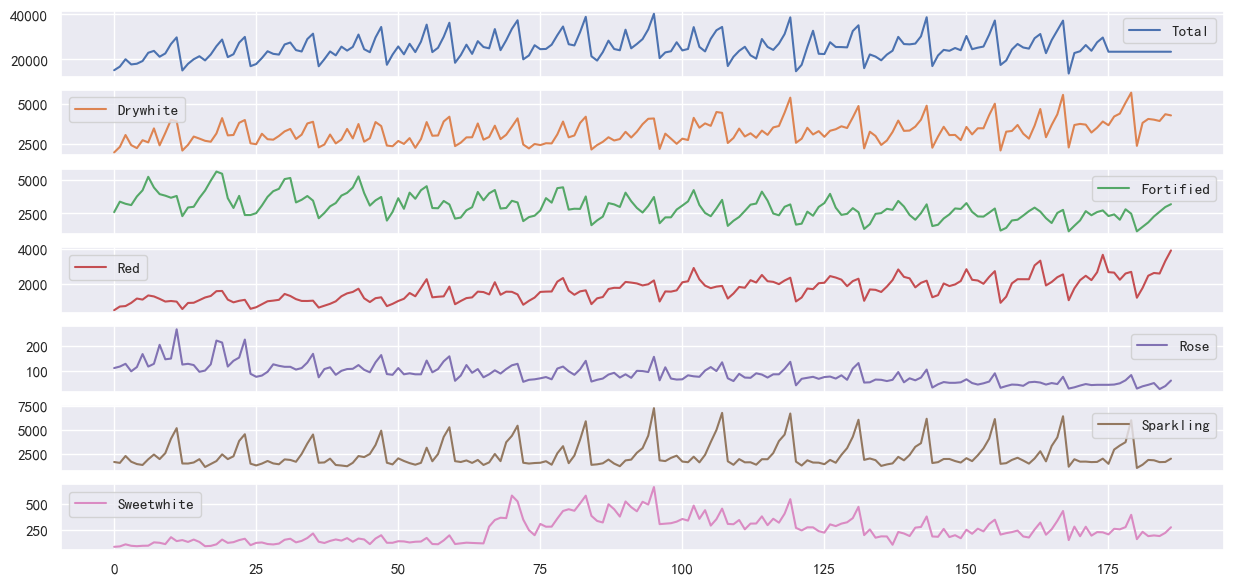

In [96]:
#3.建立VECM模型
vecm=VECM(data,coint_rank=1)
vecm_fit=vecm.fit()
print(vecm_fit.summary())

pred=vecm_fit.predict(steps=5)
print('Predictions:\n',pred)

#可视化
data.plot(subplots=True,figsize=(15,7))

首先，我们查看特征值(Eigenvalues)，有两个特征值 17.30929776 和 6.56626887。这些特征值越大，说明协整关系越强。

其次，我们查看临界值(Critical values) [[13.4294 15.4943 19.9349] [2.7055 3.8415 6.6349]]。Johansen检验提供了多个显著性水平（例如，10%，5%，1%）的临界值。特征值应大于对应的临界值才能认为存在协整关系。在这里，对于第一个特征值，它大于5%和1%的临界值，所以我们可以认为存在一个协整关系；而对于第二个特征值，它小于10%的临界值，所以我们不能认为存在第二个协整关系。

再次是参数的估计结果。coef列是各个参数的估计值，P>|z|列是参数估计的p值，[0.025, 0.975]列是参数估计的95%置信区间。在这里，无论是上证指数还是深证综指，滞后1期的上证指数和深证综指对现期的影响都不显著（p值大于0.05）。ec1的值表示了上证指数和深证综指之间的长期均衡关系，即协整关系。coef列是参数的估计值，P>|z|列是参数估计的p值，[0.025, 0.975]列是参数估计的95%置信区间。从结果来看，对于上证指数，协整关系不显著（p值大于0.05）；对于深证综指，协整关系显著（p值小于0.10）。

最后，"Cointegration relations for loading-coefficients-column 1"部分表示的是协整向量，其中beta.1为1，beta.2为-1.5178，表示的是上证指数和深证综指的协整关系可以由上证指数 - 1.5178 * 深证综指 = 0这个方程来表示。"Predictions"部分给出了上证指数和深证综指的未来5个值的预测。

总的来说，上证指数和深证综指之间存在一个显著的协整关系，且这个协整关系主要体现在深证综指上。

# 格兰杰因果检验

+ 格兰杰因果检验(Granger Causality Test)是一种用于检验一个时间序列是否能够预测另一个时间序列的统计假设检验方法。如果我们发现序列X可以帮助预测序列Y，那么我们就可以说“X对Y具有格兰杰因果关系”。

+ 需要注意的是，格兰杰因果关系并不是我们通常所说的因果关系。在格兰杰的语境中，“因果”并不意味着X直接导致了Y的变化，而仅仅是X可以预测Y。这是一个预测的概念，而不是传统意义上的因果关系。因此，格兰杰因果检验仅仅是为了检验预测关系，而不能确定实际的因果关系。

## 基本原理
假设我们有两个时间序列X和Y，我们想要检验X是否对Y具有格兰杰因果关系。我们可以建立以下两个模型：

一个只包含Y的自回归模型：
Y(t) = α0 + α1 * Y(t-1) + α2 * Y(t-2) + … + αn * Y(t-n) + ε(t)

一个包含Y和X的向量自回归模型：
Y(t) = β0 + β1 * Y(t-1) + β2 * Y(t-2) + … + βn * Y(t-n) + γ1 * X(t-1) + γ2 * X(t-2) + … + γm * X(t-m) + u(t)

如果第二个模型的预测效果显著优于第一个模型，那么我们就可以认为X对Y具有格兰杰因果关系。

## 应用领域及局限性
格兰杰因果检验在经济金融领域有广泛的应用。一些常见的应用包括：

+ 宏观经济研究。例如，检验通货膨胀率和失业率之间的关系，或者货币供应量和股票市场指数之间的关系。
+ 金融市场研究。例如，检验股票市场和债券市场之间的相互影响，或者金融市场的各种因素（例如，金融政策，投资者情绪等）对金融市场的影响。
+ 投资决策。例如，检验公司的财务报告数据和公司股票价格之间的关系，以帮助投资者做出更好的投资决策。
然而，格兰杰因果检验也有其局限性：

格兰杰因果关系并非真正的因果关系。格兰杰因果关系只是表示两个变量之间存在一种预测关系，而并不能说明这两个变量之间存在因果关系。例如，如果我们发现市场的交易量增加可以预测股票价格的上涨，但这并不能证明交易量的增加就是导致股票价格上涨的原因。

+ 可能存在滞后效应。格兰杰因果检验通常假设变量之间的关系在滞后期间内就会显现，但实际上可能存在更长的滞后效应。
+ 可能存在遗漏变量问题。格兰杰因果检验通常是基于两个变量进行的，如果存在其他未考虑的变量也对被预测变量有影响，那么检验结果可能会受到影响。
+ 预设的滞后阶数可能会影响检验结果。在进行格兰杰因果检验时，需要预设滞后阶数，这个滞后阶数的设定可能会影响检验结果。一般来说，滞后阶数的设定需要根据具体的经济理论和实证数据来进行。

因此，当我们使用格兰杰因果检验时，需要谨慎解释检验结果，并结合实际的经济理论和其他统计检验方法来进行分析。

In [97]:
#模拟两个存在格兰杰因果关系的时间序列

#设定随机数生成器的种子，以保证结果的可重复性
np.random.seed(123)

#生成第一个序列
X=np.random.normal(size=1000)

#生成第二个序列，该序列的值依赖于X序列前一期的值
Y=np.roll(X,shift=-1)+np.random.normal(size=1000)

#将两个时间序列合并成一个二维数组
data=np.column_stack([X,Y])

#进行格兰杰因果检验，最大滞后阶数设为3

results=grangercausalitytests(data,maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1237.5676, p=0.0000  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=1241.2952, p=0.0000  , df=1
likelihood ratio test: chi2=806.8005, p=0.0000  , df=1
parameter F test:         F=1237.5676, p=0.0000  , df_denom=996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=618.6395, p=0.0000  , df_denom=993, df_num=2
ssr based chi2 test:   chi2=1243.5090, p=0.0000  , df=2
likelihood ratio test: chi2=807.5330, p=0.0000  , df=2
parameter F test:         F=618.6395, p=0.0000  , df_denom=993, df_num=2


上述代码生成了两个序列X和Y，其中Y的值取决于X的前一期值和一个随机噪音。我们期待格兰杰因果检验能够检测到这种关系。对于每一个滞后阶数，我们都有一组检验结果，包括四种不同类型的检验统计量（F test, chi-square test, likelihood ratio test和parameter F test），以及对应的p值。如果p值小于设定的显著性水平（比如0.05），我们就可以拒绝原假设，认为存在Granger因果关系。在这个例子中，滞后阶数为1和2时，所有检验的p值都约等于0，所以我们拒绝原假设，认为存在Granger因果关系。

然而，注意到，这些检验结果可能受到滞后阶数的设定影响。这个滞后阶数的设定需要根据具体的经济理论和实证数据来进行。因此，在使用Granger因果检验的时候，我们需要谨慎处理并解读结果

下面我们将模拟两个白噪声时间序列，因为我们知道白噪声时间序列的数据是随机产生的，因此一个白噪声时间序列不可能对另一个白噪声时间序列有任何预测力，即它们之间不存在格兰杰因果关系。

In [98]:
#模拟两个白噪声时间序列
np.random.seed(123)
X=np.random.normal(size=10000)
Y=np.random.normal(size=10000)

#将两个时间序列合并成一个二维数组
data=np.vstack([X,Y]).T

#进行格兰杰因果检验，最大滞后阶数设为2
results=grangercausalitytests(data,maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0008  , p=0.9768  , df_denom=9996, df_num=1
ssr based chi2 test:   chi2=0.0008  , p=0.9768  , df=1
likelihood ratio test: chi2=0.0008  , p=0.9768  , df=1
parameter F test:         F=0.0008  , p=0.9768  , df_denom=9996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0488  , p=0.9524  , df_denom=9993, df_num=2
ssr based chi2 test:   chi2=0.0976  , p=0.9524  , df=2
likelihood ratio test: chi2=0.0976  , p=0.9524  , df=2
parameter F test:         F=0.0488  , p=0.9524  , df_denom=9993, df_num=2


In [99]:
data=pd.read_csv("wine.csv")
data=data.fillna(method='pad',axis=0)
data=pd.concat([data["Fortified"],data["Sparkling"]],axis=1)

In [100]:
#检验时间序列的平稳性

for column in data.columns:
    result=adfuller(data[column])

if result[1]>0.05:print(f"{column}非平稳,需要进行差分")
else:print(f"{column}平稳")

#选择滞后阶数

model=VAR(returns)
lag_order=model.select_order(maxlags=10)
print(f"最大滞后阶数：{lag_order.selected_orders['aic']}")

#进行格兰杰因果检验
maxlag=lag_order.selected_orders['aic']
test_result=grangercausalitytests(data,maxlag=maxlag)

Sparkling非平稳,需要进行差分
最大滞后阶数：10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=93.3434 , p=0.0000  , df_denom=183, df_num=1
ssr based chi2 test:   chi2=94.8736 , p=0.0000  , df=1
likelihood ratio test: chi2=76.6614 , p=0.0000  , df=1
parameter F test:         F=93.3434 , p=0.0000  , df_denom=183, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=50.4539 , p=0.0000  , df_denom=180, df_num=2
ssr based chi2 test:   chi2=103.7108, p=0.0000  , df=2
likelihood ratio test: chi2=82.3379 , p=0.0000  , df=2
parameter F test:         F=50.4539 , p=0.0000  , df_denom=180, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=37.3061 , p=0.0000  , df_denom=177, df_num=3
ssr based chi2 test:   chi2=116.3445, p=0.0000  , df=3
likelihood ratio test: chi2=90.1590 , p=0.0000  , df=3
parameter F test:         F=37.3061 , p=0.0000  , df_denom=177, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test: 

这些结果显示了深证综指和上证指数之间在不同滞后阶段的相互影响。

例如，L10.深证综指对两个方程都有显著的正向影响，而L10.上证指数对两个方程都有显著的负向影响，这可能意味着在10期的滞后下，深证综指的变化会正向影响两个市场，而上证指数的变化会负向影响两个市场。这可能与市场的具体动态和投资者的反应有关。

多元时间序列模型在经济学、金融学、社会学等领域具有广泛应用，特别是在金融市场分析和预测中，它的重要性不言而喻。随着大数据和计算能力的快速发展，这一领域的研究正面临着革命性的变化。

（1）对传统模型进行扩展和深化是未来多元时间序列研究的一大方向。其中，向量自回归模型（VAR）是多元时间序列分析的基础，但在现实应用中，存在许多限制，如参数数量过多，需要大量样本支持，可能导致过拟合等问题。因此，对VAR模型进行改进和优化，减少参数数量，提高模型鲁棒性是一大趋势。比如，可以引入贝叶斯方法进行参数估计，或者考虑模型参数的稀疏性，进行变量选择等。

（2）引入非线性和异质性是另一个重要的研究方向。在实际应用中，经济变量往往存在非线性和异质性，而传统的线性模型往往不能很好的捕捉这些特性。因此，如何将非线性和异质性结构融入多元时间序列模型是未来研究的重要任务。例如，可以构建非线性向量自回归模型，考虑异质性协整模型等。

（3）多元时间序列的大数据分析和机器学习应用正在蓬勃发展。随着大数据和计算能力的发展，传统的模型和方法已经无法满足现实需求。如何处理高维度的时间序列数据，如何利用机器学习方法进行预测和分析，如何评估预测结果的准确性和稳定性等问题，都是未来研究的重要课题。例如，可以考虑使用深度学习模型如递归神经网络（RNN）或长短期记忆网络（LSTM）进行预测，或者使用支持向量机（SVM）、随机森林、梯度提升等方法进行特征提取和分类。

（4）多元时间序列的网络分析和复杂性分析是最新的研究前沿。金融市场是一个复杂的网络系统，各个变量之间存在着复杂的相互作用和反馈机制。如何从网络的角度研究多元时间序列，如何度量和分析复杂性，如何利用这些信息进行风险管理和决策支持，是未来的一个重要研究领域。例如，可以构建金融市场的网络模型，考虑节点的连通性和稳定性，或者研究网络的复杂性，如分形维度、混沌度等。

总的来说，未来的多元时间序列模型研究将是多元化、深化和综合的，需要从多个角度和层面进行探索和实践。在这个过程中，我们期待有更多的新模型、新方法和新理论的出现，以推动这个领域的发展和进步。